In [21]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [22]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
csfont = {'fontname':'Times New Roman'}
plt.rcParams["font.family"] = "Times New Roman"
import scipy.stats as st
from scipy.stats import wilcoxon
import scikit_posthocs as sp
import random
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import skbio
from skbio.diversity import beta_diversity
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy.polynomial.polynomial as nply
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import random
random.seed(26)

# include if using a Jupyter notebook
%matplotlib inline
df = pd.read_csv('20220830_Master.csv')
df = df[(df['Block']!=1)&(df['SoilType']!="ConvFallow")]
df['WCR2to3']=df['WCR2ndInstar']/df['WCR3rdInstar']

In [23]:
dfMC = df[df['Variety']=='MastersChoice']
dfBRO = df[df['Variety']=='BlueRiverOrganic']

In [24]:
%run pairwisecomp_letters.py.ipynb
alpha=0.05

# Changes in Plant Biomass

#### ANOVA tables

Shoot Mass
                           df     sum_sq   mean_sq          F        PR(>F)
C(DateGerm)               4.0   2.752737  0.688184   9.733583  3.805194e-07
C(Variety)                1.0   1.018114  1.018114  14.400068  2.020671e-04
C(SoilType)               4.0   2.736518  0.684129   9.676232  4.162256e-07
C(Variety):C(SoilType)    4.0   0.061730  0.015432   0.218275  9.280029e-01
Residual                179.0  12.655668  0.070702        NaN           NaN
 
Root Mass
                           df     sum_sq   mean_sq         F    PR(>F)
C(DateGerm)               4.0   0.086071  0.021518  0.355533  0.839943
C(Variety)                1.0   0.224895  0.224895  3.715888  0.055480
C(SoilType)               4.0   1.433211  0.358303  5.920153  0.000170
C(Variety):C(SoilType)    4.0   0.191831  0.047958  0.792394  0.531527
Residual                179.0  10.833534  0.060523       NaN       NaN


Text(4, 1.65, 'A')

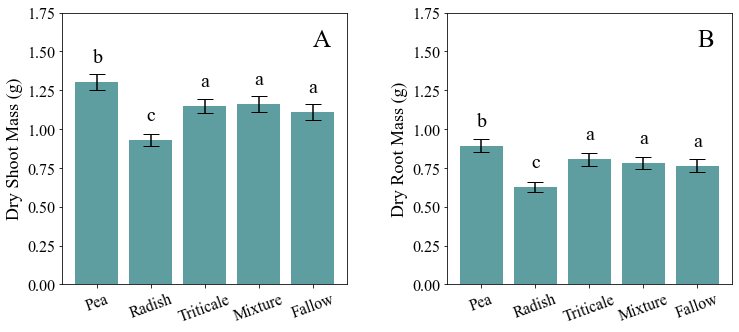

In [25]:
%matplotlib inline
fig = plt.figure(figsize=(12,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)

trtnames = ['Pea','Radish','Triticale','Mixture','Fallow']#,'Conventional \nFallow']

df_mass = df.groupby(['SoilType','WCR'], as_index=False).agg(
                      {'RootMass':['mean','sem'],'ShootMass':['mean','sem']})
df_mass = df_mass[df_mass['WCR']!='yes']
df_mass = df_mass.reindex(index = [4,6,8,2,0])
df_mass['rp_PctChange'] = (df_mass.iloc[0]['RootMass']['mean']-df_mass['RootMass']['mean'])/df_mass['RootMass']['mean']
df_mass['rr_PctChange'] = (df_mass.iloc[1]['RootMass']['mean']-df_mass['RootMass']['mean'])/df_mass['RootMass']['mean']
df_mass['sp_PctChange'] = (df_mass.iloc[0]['ShootMass']['mean']-df_mass['ShootMass']['mean'])/df_mass['ShootMass']['mean']
df_mass['sr_PctChange'] = (df_mass.iloc[1]['ShootMass']['mean']-df_mass['ShootMass']['mean'])/df_mass['ShootMass']['mean']
# print(df_mass)

roots = df[['Trt','Variety','Rep','SoilType','RootMass','DateGerm','WCR']]
roots = roots[roots['RootMass'].notna()]
roots = roots[roots['WCR']!='yes']
roots['Block'] = roots['Variety']+roots['DateGerm']
shoots = df[['Trt','Variety','Rep','SoilType','ShootMass','DateGerm','WCR']]
shoots = shoots[shoots['ShootMass'].notna()]
shoots = shoots[shoots['WCR']!='yes']
shoots['Block'] = shoots['Variety']+shoots['DateGerm']
heights = df[['Trt','Variety','Rep','SoilType','Height','DateGerm','WCR']]
heights = heights[heights['Height'].notna()]
heights = heights[heights['WCR']!='yes']
heights['Block'] = heights['Variety']+heights['DateGerm']
rootshoot = df[['Trt','Variety','Rep','SoilType','RootShootRatio','DateGerm','WCR']]
rootshoot = rootshoot[rootshoot['RootShootRatio'].notna()]
rootshoot = rootshoot[rootshoot['WCR']!='yes']
rootshoot['Block'] = rootshoot['Variety']+rootshoot['DateGerm']

data1 = [roots.loc[ids, 'RootMass'].values for ids in roots.groupby('SoilType').groups.values()]
data2 = [shoots.loc[ids, 'ShootMass'].values for ids in shoots.groupby('SoilType').groups.values()]
data3 = [heights.loc[ids, 'Height'].values for ids in heights.groupby('SoilType').groups.values()]
data4 = [rootshoot.loc[ids, 'RootShootRatio'].values for ids in rootshoot.groupby('SoilType').groups.values()]

model1 = ols('ShootMass ~ C(DateGerm)+C(Variety)+C(SoilType)+ C(Variety):C(SoilType)',data=shoots).fit()
anova1 = sm.stats.anova_lm(model1,typ=1)
print('Shoot Mass')
print(anova1)
print(' ')
x=model1.predict(shoots.loc[:,['DateGerm', 'Variety','SoilType']])
y=model1.resid
pval2 = 'PR(>F) = '+str("{:.2e}".format(anova1['PR(>F)'][1]))
pairwise_comps_df = post_hoc_df(shoots, "ShootMass", 'SoilType', 'Block',posthoc = 'nemenyi', alpha = 0.05)
median_df= shoots.groupby(['SoilType'])['ShootMass'].mean().to_frame()
for row in median_df.index:
    median_df.loc[row, 'SoilType'] = str(row[0]) + "│" + str(row[1])
median_df.set_index('SoilType', drop = True, inplace = True)   
letters_df1 = multi_comparisons_letter_df_generator(pairwise_comps_df, letter_ordering_series = median_df)
letters_df1 = letters_df1.reindex(index = ['CCPea','CCRadish','CCTriticale','CCMix','CCFallow'])#,'ConvFallow'

model2 = ols('RootMass ~ C(DateGerm)+ C(Variety)+C(SoilType)+ C(Variety):C(SoilType)',data=roots).fit()
anova2 = sm.stats.anova_lm(model2,typ=1)
print('Root Mass')
print(anova2)
x1=model2.predict(roots.loc[:,['DateGerm', 'Variety','SoilType']])
y1=model2.resid
pval1 = 'PR(>F) = '+str(round(anova2['PR(>F)'][1],4))
pairwise_comps_df = post_hoc_df(roots, "RootMass", 'SoilType', 'Block',posthoc = 'nemenyi', alpha = 0.05)
median_df= roots.groupby(['SoilType'])['RootMass'].mean().to_frame()
for row in median_df.index:
    median_df.loc[row, 'SoilType'] = str(row[0]) + "│" + str(row[1])
median_df.set_index('SoilType', drop = True, inplace = True)   
letters_df2 = multi_comparisons_letter_df_generator(pairwise_comps_df, letter_ordering_series = median_df)
letters_df2 = letters_df2.reindex(index = ['CCPea','CCRadish','CCTriticale','CCMix','CCFallow'])#,'ConvFallow'])

plt.subplot(1,2,2)
bar=plt.bar(df_mass['SoilType'], df_mass['RootMass']['mean'],
        yerr=df_mass['RootMass']['sem'], capsize=8,
        color=['cadetblue'])
for i, rectangle in enumerate(bar):
    height = rectangle.get_height()
    plt.text(rectangle.get_x() + rectangle.get_width()/2, height + 0.1,
         '%s' % (letters_df2['string'][i]),
             ha='center', va='bottom',size=20)
plt.tick_params(axis='both', which='major', labelsize=16)
n = 'n = %s'%len(roots)
plt.xticks(df_mass['SoilType'],trtnames,rotation=20)
plt.ylim(0,1.75)
plt.ylabel("Dry Root Mass (g)",size=18)
plt.text(4,1.65,'B',horizontalalignment='left',verticalalignment='top',size=25)

plt.subplot(1,2,1)
bar=plt.bar(df_mass['SoilType'], df_mass['ShootMass']['mean'],
        yerr=df_mass['ShootMass']['sem'], capsize=8,
        color=['cadetblue'])
for i, rectangle in enumerate(bar):
    height = rectangle.get_height()
    plt.text(rectangle.get_x() + rectangle.get_width()/2, height + 0.1,
         '%s' % (letters_df1['string'][i]),
             ha='center', va='bottom',size=20)
plt.tick_params(axis='both', which='major', labelsize=16)
n = 'n = %s'%len(shoots)
plt.xticks(df_mass['SoilType'],trtnames,rotation=20)
plt.ylim(0,1.75)
plt.ylabel("Dry Shoot Mass (g)",size=18)
plt.text(4,1.65,'A',horizontalalignment='left',verticalalignment='top',size=25)

# plt.savefig("Experiment3_RootShoot.pdf", transparent=True)

### Checking ANOVA assumptions

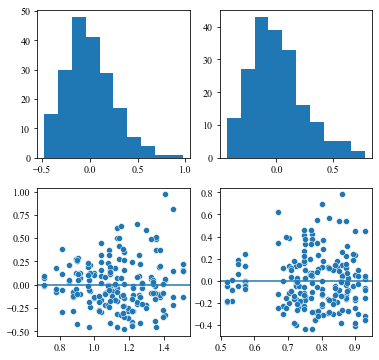

In [26]:
# check assumptions
fig = plt.figure(figsize=(6,6))

# residuals are normally distributed
plt.subplot(2,2,1)
plt.hist(y)

plt.subplot(2,2,2)
plt.hist(y1)

# homoscedacity/homogeneity test
plt.subplot(2,2,3)
sns.scatterplot(x=x, y=y)
plt.axhline(y=0)

plt.subplot(2,2,4)
sns.scatterplot(x=x1, y=y1)
plt.axhline(y=0)

Pea plants had significantly greater biomass above- and below-ground compared to other treatments 
Roots: 42% more than Radish, 11% more than Triticale, 14% more than Mix, and 17% more than Fallow; 
Shoots: 40% more than Radish, 13% more than Triticale, 12% more than Mix, and 17% more than Fallow. 

Similarly, plants after radish had significantly less biomass.
Roots: radish had 30% less than Pea, 22% less than triticale, 20% less than Mix, and 18% less than Fallow;
Shoots: radish had 29% less than Pea, 19% less than triticale, 20% less than Mix and 16% less than fallow.

# Changes in WCR Performance

#### ANOVA tables

WCR Survival Anova 
                            df    sum_sq   mean_sq         F    PR(>F)
C(DateGerm)               4.0  0.870924  0.217731  6.160977  0.000112
C(SoilType)               4.0  0.079174  0.019794  0.560084  0.691918
C(Variety)                1.0  0.007242  0.007242  0.204932  0.651296
C(SoilType):C(Variety)    4.0  0.092810  0.023203  0.656547  0.622969
Residual                186.0  6.573303  0.035340       NaN       NaN
WCR log Average Weight Anova 
                            df     sum_sq   mean_sq          F        PR(>F)
C(DateGerm)               4.0  24.727092  6.181773  20.371803  1.259231e-13
C(SoilType)               4.0   2.590904  0.647726   2.134557  7.883795e-02
C(Variety)                1.0   0.437232  0.437232   1.440880  2.317386e-01
C(SoilType):C(Variety)    4.0   4.289868  1.072467   3.534275  8.538470e-03
Residual                163.0  49.461946  0.303448        NaN           NaN


Text(0, 0.5, '% Larvae to Reach 3rd Instar')

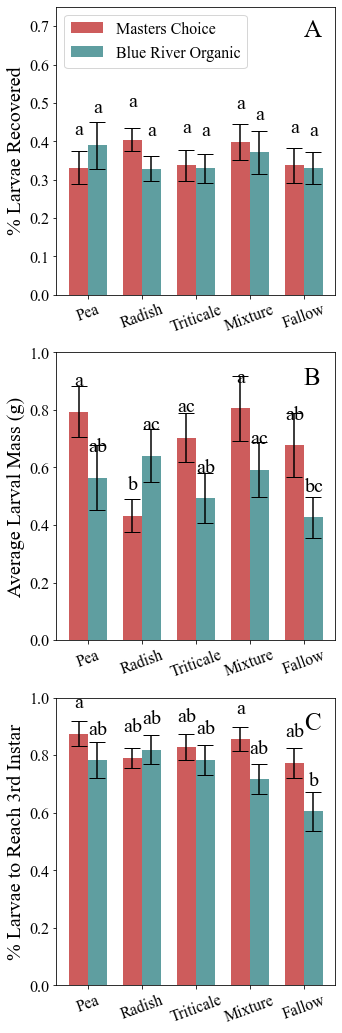

In [27]:
%matplotlib inline

fig = plt.figure(figsize=(5,18))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.2)

# for stats
df['logWeightAvg']=np.log(df['WCRWeightAvg'],out=np.zeros_like(df['WCRWeightAvg']), where=(df['WCRWeightAvg']!=0))
df['logTotalWeight']=np.log(df['WCRTotalWeight'],out=np.zeros_like(df['WCRTotalWeight']), where=(df['WCRTotalWeight']!=0))
df['log3rdInstar']=np.log(df['WCR3rdInstar'],out=np.zeros_like(df['WCR3rdInstar']), where=(df['WCR3rdInstar']!=0))
df['logInstarAvg']=np.log(df['WCRInstarAvg'],out=np.zeros_like(df['WCRInstarAvg']), where=(df['WCRInstarAvg']!=0))
df['WCR3_2']=(df['WCR3rdInstar']-df['WCR2ndInstar'])#*df['WCRRecovered']

# for graphs
df_wcr = df.groupby(['SoilType','Variety'], as_index=False).agg(
                      {'WCRSurvival':['mean','sem'],'WCRWeightAvg':['mean','sem'],'logWeightAvg':['mean','sem'],'WCRHeadCap':['mean','sem'],
                       'WCRTotalWeight':['mean','sem'], 'WCRInstarAvg':['mean','sem'],'WCR3rdInstar':['mean','sem'], 'WCR2ndInstar':['mean','sem']})
df_wcrMC = df_wcr[df_wcr['Variety']=='MastersChoice']
df_wcrMC = df_wcrMC.reindex(index = [5,7,9,3,1])
df_wcrBRO = df_wcr[df_wcr['Variety']=='BlueRiverOrganic']
df_wcrBRO = df_wcrBRO.reindex(index = [4,6,8,2,0])

df_wcr = df.groupby(['SoilType'], as_index=False).agg(
                      {'WCRSurvival':['mean','sem'],'WCRWeightAvg':['mean','sem'],'logWeightAvg':['mean','sem'],'WCRHeadCap':['mean','sem'],
                       'WCRTotalWeight':['mean','sem'], 'WCR3_2':['mean','sem'],'log3rdInstar':['mean','sem'], 'WCR2ndInstar':['mean','sem']})
df_wcr = df_wcr.reindex(index = [2,3,4,1,0])

wcrs = df[['Trt','Rep','Variety','SoilType','WCRSurvival','DateGerm']]
wcrs = wcrs[wcrs['WCRSurvival'].notna()]
wcrs['Block'] = wcrs['DateGerm']+wcrs['Variety']
wcrs['Trt'] = wcrs['SoilType']+wcrs['Variety']
wcrma = df[['Trt','Rep','Variety','SoilType','logWeightAvg','DateGerm']]
wcrma = wcrma[wcrma['logWeightAvg'].notna()]
wcrma['Trt'] = wcrma['SoilType']+wcrma['Variety']
wcrma['Block'] = wcrma['DateGerm']+wcrma['Variety']
# wcrmt = df[['Trt','Rep','Variety','SoilType','logTotalWeight','DateGerm']]
# wcrmt = wcrmt[wcrmt['logTotalWeight'].notna()]
# wcrmt['Trt'] = wcrmt['SoilType']+wcrmt['Variety']
# wcrmt['Block'] = wcrmt['DateGerm']
# wcrh = df[['Trt','Rep','Variety','SoilType','WCRHeadCap','DateGerm']]
# wcrh = wcrh[wcrh['WCRHeadCap'].notna()]
# wcrh['Trt'] = wcrh['SoilType']+wcrh['Variety']
# wcrh['Block'] = wcrh['DateGerm']
wcri = df[['Trt','Rep','Variety','SoilType','WCR3rdInstar','DateGerm']]
wcri = wcri[wcri['WCR3rdInstar'].notna()]
wcri['Trt'] = wcri['SoilType']+wcri['Variety']
wcri['Block'] = wcri['DateGerm']
# wcria = df[['Trt','Rep','Variety','SoilType','WCR2ndInstar','DateGerm']]
# wcria = wcria[wcria['WCR2ndInstar'].notna()]
# wcria['Trt'] = wcria['SoilType']+wcria['Variety']
# wcria['Block'] = wcria['DateGerm']

model1 = ols('WCRSurvival ~ C(DateGerm) + C(SoilType)*C(Variety)',data=wcrs).fit()
anova1 = sm.stats.anova_lm(model1,typ=1)
xs=model1.predict(wcrs.loc[:,['DateGerm', 'Variety','SoilType']])
ys=model1.resid
pval1 = 'PR(>F) = '+str(round(anova1['PR(>F)'][1],4))
pairwise_comps_df = post_hoc_df(wcrs, "WCRSurvival", 'Trt', 'Block',posthoc = 'nemenyi', alpha = 0.05)
letters_df1 = multi_comparisons_letter_df_generator(pairwise_comps_df)
letters_df1 = letters_df1.reindex(index = ['CCPeaMastersChoice','CCPeaBlueRiverOrganic',
                                           'CCRadishMastersChoice','CCRadishBlueRiverOrganic',
                                           'CCTriticaleMastersChoice','CCTriticaleBlueRiverOrganic',
                                           'CCMixMastersChoice','CCMixBlueRiverOrganic',
                                           'CCFallowMastersChoice','CCFallowBlueRiverOrganic'])
print('WCR Survival Anova',"\n",anova1)
width=0.35
xbar = np.arange(5)  # the label locations
matchingMC = [s for s in letters_df1.index if "MastersChoice" in s]
lettersMC = letters_df1[letters_df1.index.isin(matchingMC)]
matchingBRO = [s for s in letters_df1.index if "BlueRiverOrganic" in s]
lettersBRO = letters_df1[letters_df1.index.isin(matchingBRO)]
plt.subplot(3,1,1)
bar1=plt.bar(x=(xbar - width/2), height=df_wcrMC['WCRSurvival']['mean'],width=width,
        yerr=df_wcrMC['WCRSurvival']['sem'], capsize=8,
        color=['indianred'], label="Masters Choice")
bar2=plt.bar(x=(xbar + width/2), height=df_wcrBRO['WCRSurvival']['mean'],width=width,
        yerr=df_wcrBRO['WCRSurvival']['sem'], capsize=8,
        color=['cadetblue'], label="Blue River Organic")
for i, rectangle in enumerate(bar1):
    height = rectangle.get_height()
    plt.text(rectangle.get_x() + rectangle.get_width()/2, height + 0.075,
         '%s' % (lettersMC['string'][i]),
             ha='center', va='bottom',size=20)
for i, rectangle in enumerate(bar2):
    height = rectangle.get_height()
    plt.text(rectangle.get_x() + rectangle.get_width()/2, height + 0.075,
         '%s' % (lettersBRO['string'][i]),
             ha='center', va='bottom',size=20)
# plt.title('WCR Survival (%) \n(mean $\pm$ sem)',fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=16)
n = 'n = %s'%len(wcrs)
plt.text(4,0.72,"A",horizontalalignment='left',verticalalignment='top',size=25)
plt.xticks([0,1,2,3,4],trtnames,rotation=20)
plt.ylim(0,0.75)
plt.ylabel('% Larvae Recovered',size=20)
plt.legend(loc='upper left',fontsize=16)


model1 = ols('logWeightAvg ~ C(DateGerm) + C(SoilType)*C(Variety)',data=wcrma).fit()
anova1 = sm.stats.anova_lm(model1,typ=1)
xma=model1.predict(wcrma.loc[:,['DateGerm', 'Variety','SoilType']])
yma=model1.resid
pval1 = 'PR(>F) = '+str(round(anova1['PR(>F)'][1],4))
pairwise_comps_df = post_hoc_df(wcrma, "logWeightAvg", 'Trt', 'Block',posthoc = 'nemenyi', alpha = 0.05)
letters_df1 = multi_comparisons_letter_df_generator(pairwise_comps_df)
letters_df1 = letters_df1.reindex(index = ['CCPeaMastersChoice','CCPeaBlueRiverOrganic',
                                           'CCRadishMastersChoice','CCRadishBlueRiverOrganic',
                                           'CCTriticaleMastersChoice','CCTriticaleBlueRiverOrganic',
                                           'CCMixMastersChoice','CCMixBlueRiverOrganic',
                                           'CCFallowMastersChoice','CCFallowBlueRiverOrganic'])
print('WCR log Average Weight Anova',"\n",anova1)

width=0.35
xbar = np.arange(5)  # the label locations
matchingMC = [s for s in letters_df1.index if "MastersChoice" in s]
lettersMC = letters_df1[letters_df1.index.isin(matchingMC)]
matchingBRO = [s for s in letters_df1.index if "BlueRiverOrganic" in s]
lettersBRO = letters_df1[letters_df1.index.isin(matchingBRO)]
plt.subplot(3,1,2)

lettersMC2 = ['a','b','ab','a','ab']
lettersBRO2 = ['ab','ab','ab','ab','ab']

bar1=plt.bar(x=(xbar - width/2), height=df_wcrMC['WCRWeightAvg']['mean'],width=width,
        yerr=df_wcrMC['WCRWeightAvg']['sem'], capsize=8,
        color=['indianred'])
bar2=plt.bar(x=(xbar + width/2), height=df_wcrBRO['WCRWeightAvg']['mean'],width=width,
        yerr=df_wcrBRO['WCRWeightAvg']['sem'], capsize=8,
        color=['cadetblue'], label="Blue River Organic")
for i, rectangle in enumerate(bar1):
    height = rectangle.get_height()
    plt.text(rectangle.get_x() + rectangle.get_width()/2, height + 0.075,
         '%s' % (lettersMC['string'][i]),
             ha='center', va='bottom',size=20)
for i, rectangle in enumerate(bar2):
    height = rectangle.get_height()
    plt.text(rectangle.get_x() + rectangle.get_width()/2, height + 0.075,
         '%s' % (lettersBRO['string'][i]),
             ha='center', va='bottom',size=20)
# plt.title('Average Larval Mass \n(mean $\pm$ sem)',fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=16)
n = 'n = %s'%len(wcrma)
plt.text(4,0.95,"B",horizontalalignment='left',verticalalignment='top',size=25)
plt.xticks([0,1,2,3,4],trtnames,rotation=20)
plt.ylim(0,1)
plt.ylabel('Average Larval Mass (g)',size=20)

width=0.35
xbar = np.arange(5)  # the label locations
matchingMC = [s for s in letters_df1.index if "MastersChoice" in s]
lettersMC = letters_df1[letters_df1.index.isin(matchingMC)]
matchingBRO = [s for s in letters_df1.index if "BlueRiverOrganic" in s]
lettersBRO = letters_df1[letters_df1.index.isin(matchingBRO)]
plt.subplot(3,1,3)
bar1=plt.bar(x=(xbar - width/2), height=df_wcrMC['WCR3rdInstar']['mean'],width=width,
        yerr=df_wcrMC['WCR3rdInstar']['sem'], capsize=8,
        color=['indianred'],label="Masters Choice")
bar2=plt.bar(x=(xbar + width/2), height=df_wcrBRO['WCR3rdInstar']['mean'],width=width,
        yerr=df_wcrBRO['WCR3rdInstar']['sem'], capsize=8,
        color=['cadetblue'], label="Blue River Organic")
lettersMC2 = ['a','ab','ab','a','ab']
lettersBRO2 = ['ab','ab','ab','ab','b']
for i, rectangle in enumerate(bar1):
    height = rectangle.get_height()
    plt.text(rectangle.get_x() + rectangle.get_width()/2, height + 0.075,
         '%s' % (lettersMC2[i]),
             ha='center', va='bottom',size=20)
for i, rectangle in enumerate(bar2):
    height = rectangle.get_height()
    plt.text(rectangle.get_x() + rectangle.get_width()/2, height + 0.075,
         '%s' % (lettersBRO2[i]),
             ha='center', va='bottom',size=20)
# plt.title('3rd Instar \n(mean $\pm$ sem)',fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.text(4,0.95,"C",horizontalalignment='left',verticalalignment='top',size=25)
plt.xticks([0,1,2,3,4],trtnames,rotation=20)
plt.ylim(0,1)
plt.ylabel('% Larvae to Reach 3rd Instar',size=20)

# plt.savefig("Experiment3_WCR3.pdf", transparent=True)

#### Kruskal-Wallis Tables

In [28]:
wcr2 = df[['Trt','Rep','Variety','SoilType','WCR3_2','WCRInstarAvg','WCR3rdInstar','DateGerm']]
wcr2 = wcr2[wcr2['WCR3_2'].notna()]

MCfallow = wcr2[(wcr2['Variety']=='MastersChoice')&(wcr2['SoilType']=='CCFallow')]['WCR3rdInstar']
MCpea = wcr2[(wcr2['Variety']=='MastersChoice')&(wcr2['SoilType']=='CCPea')]['WCR3rdInstar']
MCradish = wcr2[(wcr2['Variety']=='MastersChoice')&(wcr2['SoilType']=='CCRadish')]['WCR3rdInstar']
MCtriticale = wcr2[(wcr2['Variety']=='MastersChoice')&(wcr2['SoilType']=='CCTriticale')]['WCR3rdInstar']
MCmix = wcr2[(wcr2['Variety']=='MastersChoice')&(wcr2['SoilType']=='CCMix')]['WCR3rdInstar']
BROfallow = wcr2[(wcr2['Variety']=='BlueRiverOrganic')&(wcr2['SoilType']=='CCFallow')]['WCR3rdInstar']
BROpea = wcr2[(wcr2['Variety']=='BlueRiverOrganic')&(wcr2['SoilType']=='CCPea')]['WCR3rdInstar']
BROradish = wcr2[(wcr2['Variety']=='BlueRiverOrganic')&(wcr2['SoilType']=='CCRadish')]['WCR3rdInstar']
BROtriticale = wcr2[(wcr2['Variety']=='BlueRiverOrganic')&(wcr2['SoilType']=='CCTriticale')]['WCR3rdInstar']
BROmix = wcr2[(wcr2['Variety']=='BlueRiverOrganic')&(wcr2['SoilType']=='CCMix')]['WCR3rdInstar']
print("kruskal-wallis Masters Choice by Cover Crop")
print(st.kruskal(MCfallow,MCpea,MCradish,MCtriticale,MCmix))
kw_list = [MCfallow,MCpea,MCradish,MCtriticale,MCmix]
print(sp.posthoc_dunn(kw_list, p_adjust = 'holm'))
print()
print("kruskal-wallis Blue River Organic by Cover Crop")
print(st.kruskal(BROfallow,BROpea,BROradish,BROtriticale,BROmix))
kw_list = [BROfallow,BROpea,BROradish,BROtriticale,BROmix]
print(sp.posthoc_dunn(kw_list, p_adjust = 'holm'))
print()
print("kruskal-wallis by Variety and Cover Crop")
print(st.kruskal(MCfallow,BROfallow,MCpea,BROpea,MCradish,BROradish,MCtriticale,BROtriticale,MCmix,BROmix))
kw_list = [MCfallow,BROfallow,MCpea,BROpea,MCradish,BROradish,MCtriticale,BROtriticale,MCmix,BROmix]
print(sp.posthoc_dunn(kw_list, p_adjust = 'holm'))

fallow = wcr2[(wcr2['SoilType']=='CCFallow')]['WCR3rdInstar']
pea = wcr2[(wcr2['SoilType']=='CCPea')]['WCR3rdInstar']
radish = wcr2[(wcr2['SoilType']=='CCRadish')]['WCR3rdInstar']
triticale = wcr2[(wcr2['SoilType']=='CCTriticale')]['WCR3rdInstar']
mix = wcr2[(wcr2['SoilType']=='CCMix')]['WCR3rdInstar']
print()
print("kruskal-wallis by Cover Crop")
print(st.kruskal(fallow,pea,radish,triticale,mix))
kw_list = [fallow,pea,radish,triticale,mix]
print(sp.posthoc_dunn(kw_list, p_adjust = 'holm'))

masterschoice = wcr2[(wcr2['Variety']=='MastersChoice')]['WCR3rdInstar']
blueriverorganic = wcr2[(wcr2['Variety']=='BlueRiverOrganic')]['WCR3rdInstar']

print("kruskal-wallis by Variety")
print(st.kruskal(masterschoice,blueriverorganic))
kw_list = [masterschoice,blueriverorganic]
print(sp.posthoc_dunn(kw_list, p_adjust = 'holm'))


kruskal-wallis Masters Choice by Cover Crop
KruskalResult(statistic=5.802757118197013, pvalue=0.2143706845316523)
          1         2         3    4         5
1  1.000000  0.779831  1.000000  1.0  1.000000
2  0.779831  1.000000  0.445114  1.0  1.000000
3  1.000000  0.445114  1.000000  1.0  0.855864
4  1.000000  1.000000  1.000000  1.0  1.000000
5  1.000000  1.000000  0.855864  1.0  1.000000

kruskal-wallis Blue River Organic by Cover Crop
KruskalResult(statistic=8.625069235989292, pvalue=0.07118554025914763)
          1         2         3         4         5
1  1.000000  0.255657  0.108939  0.351488  1.000000
2  0.255657  1.000000  1.000000  1.000000  1.000000
3  0.108939  1.000000  1.000000  1.000000  0.854066
4  0.351488  1.000000  1.000000  1.000000  1.000000
5  1.000000  1.000000  0.854066  1.000000  1.000000

kruskal-wallis by Variety and Cover Crop
KruskalResult(statistic=18.64901651335815, pvalue=0.028348248411247872)
     1         2         3         4    5         6       

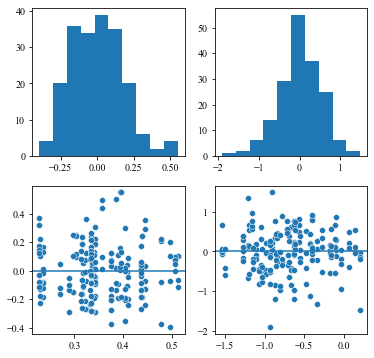

In [42]:
# check assumptions
fig = plt.figure(figsize=(6,6))

# residuals are normally distributed
plt.subplot(2,2,1)
plt.hist(ys)

plt.subplot(2,2,2)
plt.hist(yma)

# homoscedacity/homogeneity test
plt.subplot(2,2,3)
sns.scatterplot(x=xs, y=ys)
plt.axhline(y=0)

plt.subplot(2,2,4)
sns.scatterplot(x=xma, y=yma)
plt.axhline(y=0)

There was no significant difference in WCR survival between the cover crop treatments or by variety.

There was an interactive effect between variety and cover crop in terms of WCR weight, where WCR were bigger feeding on the MC variety in all cover crops except Radish, where larvae feeding on BRO plants were larger.

There was no significant difference in WCR development (% larve to reach 3rd instar) between the cover crop treatments or by variety.

# Microbiome Data

## Bray-Curtis Distances

In [30]:
dist_df = pd.read_csv('MicrobiomeData/Timpoint_Distances.csv')
dist_df=dist_df.rename({'16S_dist': 'dist16S', 'ITS_dist': 'distITS'}, axis=1) 

In [31]:
crosstab = pd.crosstab(dist_df['dist16S'], dist_df['distITS'])
# st.chi2_contingency(crosstab)

### Bacteria vs. Fungi

In [32]:
ttest_dist=st.ttest_ind(dist_df['dist16S'], dist_df['distITS'], equal_var=False, nan_policy='omit')
pval='{:0.3e}'.format(ttest_dist[1])
pval='p-value = '+str(pval)
ttest_dist

Ttest_indResult(statistic=42.91781818212657, pvalue=7.119512641057675e-79)

Text(0, 0.5, 'Bray-Curtis Distance')

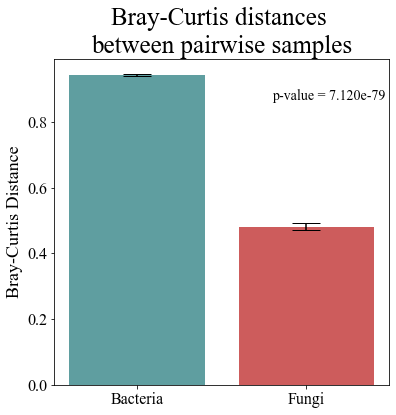

In [33]:
fig = plt.figure(figsize=(6,6))
dist_agg = dist_df.agg(['mean','sem'])
bar=plt.bar(dist_agg.columns, 
            dist_agg.iloc[0,:],
            yerr=dist_agg.iloc[1,:], capsize=14,
            color=['cadetblue','indianred'])
plt.title('Bray-Curtis distances \nbetween pairwise samples',fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(dist_agg.columns,['Bacteria','Fungi'])
plt.text(0.8,0.9,pval,horizontalalignment='left',verticalalignment='top',size=14)
# plt.ylim(0,0.075)
plt.ylabel("Bray-Curtis Distance",size=18)

# plt.savefig("Experiment3_BrayCurtis16SvsITS.pdf", transparent=True)

The bacterial microbiome changed significantly more pre-planting to post-planting compared to the fungal microbiome.

### Master's Choice vs. Blue River Organic (Bacteria)

In [34]:
trt_dict = pd.Series(df.SoilType.values,index=df.Sample).to_dict()
dist_df['SoilType']=dist_df['Sample'].map(trt_dict)
block_dict = pd.Series(df.Block.values,index=df.Sample).to_dict()
dist_df['Block']=dist_df['Sample'].map(block_dict)
var_dict = pd.Series(df.Variety.values,index=df.Sample).to_dict()
dist_df['Variety']=dist_df['Sample'].map(var_dict)

dist16S_MC = dist_df[dist_df['Variety']=='MastersChoice']['dist16S']
dist16S_BRO = dist_df[dist_df['Variety']=='BlueRiverOrganic']['dist16S']

ttest_16S_var=st.ttest_ind(dist16S_MC, dist16S_BRO, equal_var=False, nan_policy='omit')
print(ttest_16S_var)

Ttest_indResult(statistic=-4.406799859326435, pvalue=2.4992793121565592e-05)


Text(0, 0.5, 'Bray-Curtis Distance')

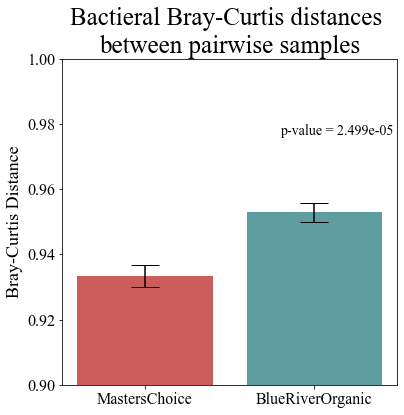

In [35]:
fig = plt.figure(figsize=(6,6))
pval='{:0.3e}'.format(ttest_16S_var[1])
pval='p-value = '+str(pval)
bar=plt.bar([0,1], 
            [dist16S_MC.mean(),dist16S_BRO.mean()],
            yerr=[dist16S_MC.sem(),dist16S_BRO.sem()], capsize=14,
            color=['indianred','cadetblue'])
plt.title('Bactieral Bray-Curtis distances \nbetween pairwise samples',fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks([0,1],['MastersChoice','BlueRiverOrganic'])
plt.text(0.8,0.98,pval,horizontalalignment='left',verticalalignment='top',size=14)
plt.ylim(0.9,1)
plt.ylabel("Bray-Curtis Distance",size=18)

The bacterial microbiome for BRO corn changed significantly more than the bacterial microbiome for the MC corn.

### Master's Choice vs. Blue River Organic (Fungi)

In [36]:
distITS_MC = dist_df[dist_df['Variety']=='MastersChoice']['distITS']
distITS_BRO = dist_df[dist_df['Variety']=='BlueRiverOrganic']['distITS']

ttest_ITS_var=st.ttest_ind(distITS_MC, distITS_BRO, equal_var=False, nan_policy='omit')
print(ttest_ITS_var)

Ttest_indResult(statistic=1.2921133826369025, pvalue=0.1988824414662343)


Text(0, 0.5, 'Bray-Curtis Distance')

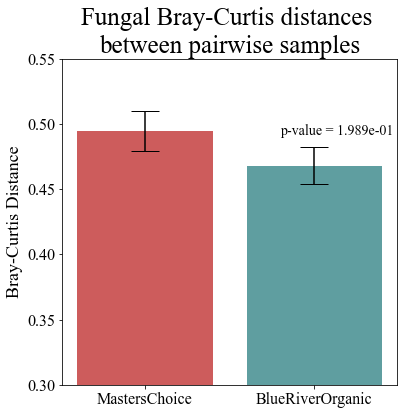

In [37]:
fig = plt.figure(figsize=(6,6))
pval='{:0.3e}'.format(ttest_ITS_var[1])
pval='p-value = '+str(pval)
bar=plt.bar([0,1], 
            [distITS_MC.mean(),distITS_BRO.mean()],
            yerr=[distITS_MC.sem(),distITS_BRO.sem()], capsize=14,
            color=['indianred','cadetblue'])
plt.title('Fungal Bray-Curtis distances \nbetween pairwise samples',fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks([0,1],['MastersChoice','BlueRiverOrganic'])
plt.text(0.8,0.5,pval,horizontalalignment='left',verticalalignment='top',size=14)
plt.ylim(0.3,.55)
plt.ylabel("Bray-Curtis Distance",size=18)

There was no significant difference between the changes to the fungal microbiome pre- to post-planting based on variety.

### by Cover Crop (Bacteria)

                          df    sum_sq   mean_sq          F    PR(>F)
C(Block)                 3.0  0.004161  0.001387   2.867925  0.040468
C(Variety)               1.0  0.010293  0.010293  21.282858  0.000012
C(SoilType)              4.0  0.005203  0.001301   2.689649  0.035570
C(Variety):C(SoilType)   4.0  0.004126  0.001032   2.132914  0.082493
Residual                97.0  0.046911  0.000484        NaN       NaN


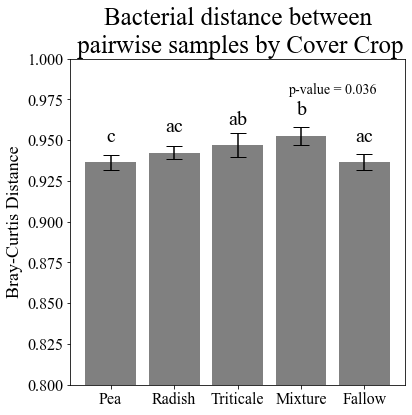

In [38]:
fig = plt.figure(figsize=(6,6))

model1 = ols('dist16S ~ C(Block)+C(Variety)+C(SoilType)+ C(Variety):C(SoilType)',data=dist_df).fit()
anova1 = sm.stats.anova_lm(model1,typ=1)
print(anova1)
pval=round(anova1['PR(>F)'][2],3)
pval='p-value = '+str(pval)
pairwise_comps_df = post_hoc_df(dist_df, "dist16S", 'SoilType', 'Block',posthoc = 'nemenyi', alpha = 0.05)
letters_df1 = multi_comparisons_letter_df_generator(pairwise_comps_df)
letters_df1 = letters_df1.reindex(index = ['CCPea','CCRadish','CCTriticale','CCMix','CCFallow'])
dist_trt_agg = dist_df.groupby(['SoilType'], as_index=False).agg(
                      {'dist16S':['mean','sem'],'distITS':['mean','sem']})
dist_trt_agg = dist_trt_agg.reindex(index = [2,3,4,1,0])

bar=plt.bar(dist_trt_agg['SoilType'], 
            dist_trt_agg['dist16S']['mean'],
            yerr=dist_trt_agg['dist16S']['sem'], capsize=8,
            color=['gray'])
for i, rectangle in enumerate(bar):
    height = rectangle.get_height()
    plt.text(rectangle.get_x() + rectangle.get_width()/2, height+0.01,
         '%s' % (letters_df1['string'][i]),
             ha='center', va='bottom',size=20)
plt.ylim(0.8,1)
plt.title('Bacterial distance between\n pairwise samples by Cover Crop',fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks([0,1,2,3,4],['Pea','Radish','Triticale','Mixture','Fallow'])
plt.text(2.8,0.985,pval,horizontalalignment='left',verticalalignment='top',size=14)
plt.ylabel("Bray-Curtis Distance",size=18)

plt.savefig("Experiment3_BrayCurtis16S_covercrop.pdf", transparent=True,bbox_inches = "tight")

#### Check Assumptions

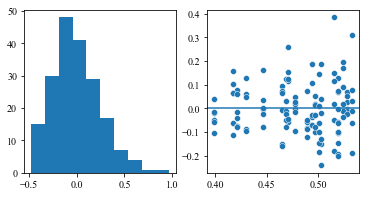

In [43]:
fig = plt.figure(figsize=(6,3))
x1=model1.predict(dist_df.loc[:,['Block', 'Variety','SoilType']])
y1=model1.resid
plt.subplot(1,2,1)
plt.hist(y)
plt.subplot(1,2,2)
sns.scatterplot(x=x1, y=y1)
plt.axhline(y=0)

The bacterial microbiome changed significantly more pre- to post-planting in the Triticale and Mixture cover crop treatment compared to the Pea cover crop treatment.

### by Cover Crop (Fungi)

                df    sum_sq   mean_sq         F    PR(>F)
C(Block)       3.0  0.017587  0.005862  0.480198  0.696712
C(SoilType)    4.0  0.166212  0.041553  3.403687  0.011491
Residual     111.0  1.355117  0.012208       NaN       NaN


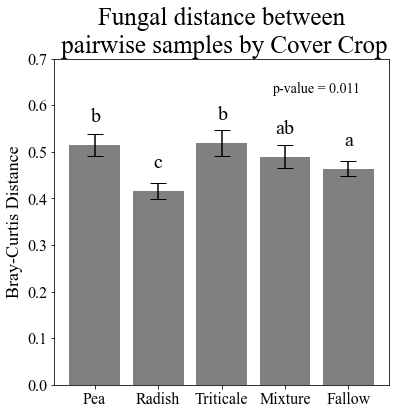

In [40]:
fig = plt.figure(figsize=(6,6))

model1 = ols('distITS ~ C(Block)+C(SoilType)',data=dist_df).fit()
anova1 = sm.stats.anova_lm(model1,typ=1)
print(anova1)
pval=round(anova1['PR(>F)'][1],3)
pval='p-value = '+str(pval)
pairwise_comps_df = post_hoc_df(dist_df, "distITS", 'SoilType', 'Block',posthoc = 'nemenyi', alpha = 0.05)
letters_df1 = multi_comparisons_letter_df_generator(pairwise_comps_df)
letters_df1 = letters_df1.reindex(index = ['CCPea','CCRadish','CCTriticale','CCMix','CCFallow'])

dist_trt_agg = dist_df.groupby(['SoilType'], as_index=False).agg(
                      {'distITS':['mean','sem'],'distITS':['mean','sem']})
dist_trt_agg = dist_trt_agg.reindex(index = [2,3,4,1,0])
bar=plt.bar(dist_trt_agg['SoilType'], 
            dist_trt_agg['distITS']['mean'],
            yerr=dist_trt_agg['distITS']['sem'], capsize=8,
            color=['gray'])
for i, rectangle in enumerate(bar):
    height = rectangle.get_height()
    plt.text(rectangle.get_x() + rectangle.get_width()/2, height+0.04,
         '%s' % (letters_df1['string'][i]),
             ha='center', va='bottom',size=20)
plt.ylim(0,0.7)
plt.title('Fungal distance between\n pairwise samples by Cover Crop',fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks([0,1,2,3,4],['Pea','Radish','Triticale','Mixture','Fallow'])
plt.text(2.8,0.65,pval,horizontalalignment='left',verticalalignment='top',size=14)
plt.ylabel("Bray-Curtis Distance",size=18)

plt.savefig("Experiment3_BrayCurtisITS_covercrop.pdf", transparent=True,bbox_inches = "tight")

#### Check Assumptions

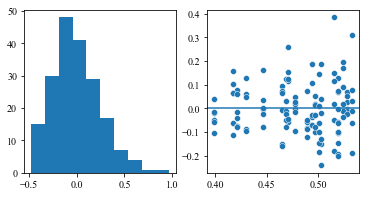

In [41]:
fig = plt.figure(figsize=(6,3))
x1=model1.predict(dist_df.loc[:,['Block','SoilType']])
y1=model1.resid
plt.subplot(1,2,1)
plt.hist(y)
plt.subplot(1,2,2)
sns.scatterplot(x=x1, y=y1)
plt.axhline(y=0)

The fungal microbiome changed significantly more pre- to post-planting in the Triticale and Pea cover crop treatment compared to the Radish cover crop treatment.